# Projet "Capitals Learning"
## Classification d'images de capitales du monde

Groupe : Paul ANACLET, Nicolas CORMARY, Sylvain CROUZET, Théo DESPRATS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

from features.load_data import load_data
from features.get_classes import get_classes
from data.dispatch_data import dispatch_data
from visualization.plot_classes_repartition import plot_classes_repartition

2022-04-18 13:54:47.172480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-18 13:54:47.172525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Chargement des données

### Répartition des images

In [2]:
# Répartition des images dans les différents datasets
pourcentageTrain = 70
pourcentageTest = 15
pourcentageValidation = 15

dispatch_data(pourcentageTrain, pourcentageTest, pourcentageValidation)


Images successfully dispatched.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['paris', 'newyork', 'tokyo'] [[291, 316, 347], [61, 67, 73], [61, 67, 73]]


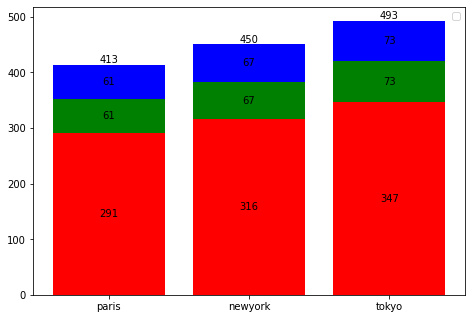

In [1]:
plot_classes_repartition()

### Chargement des images

In [50]:
CLASSES = get_classes()
IMAGE_SIZE = 64

x_train, y_train = load_data(dataset='train', image_size=IMAGE_SIZE)
x_val, y_val = load_data(dataset='validation', image_size=IMAGE_SIZE)
x_test, y_test = load_data(dataset='test', image_size=IMAGE_SIZE)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

### Visualisation des images

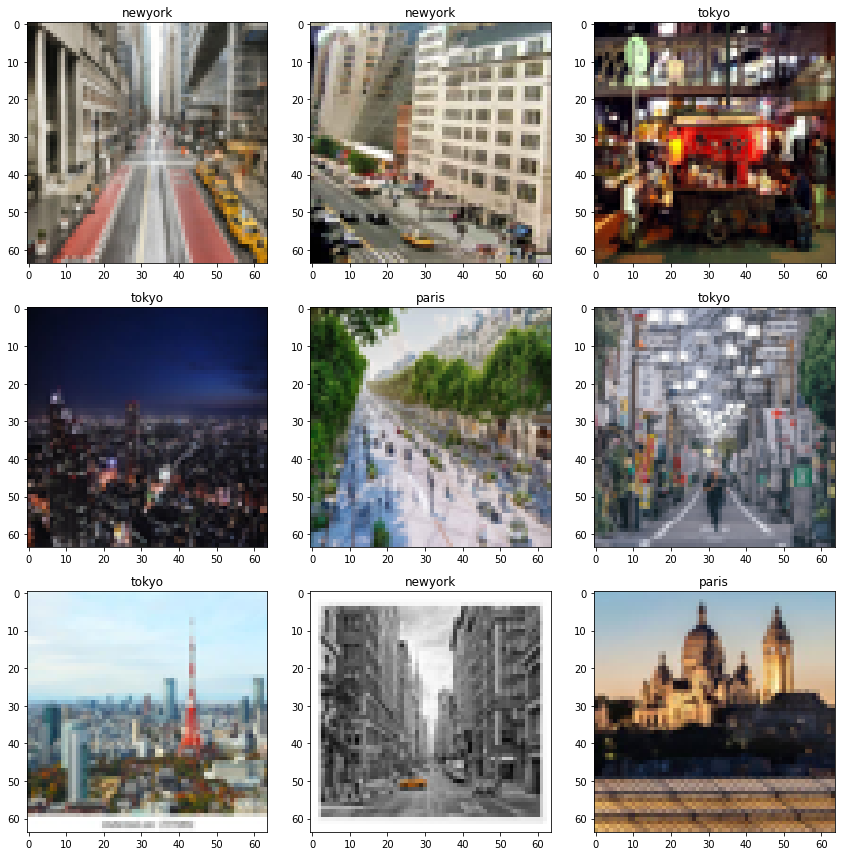

In [51]:
%matplotlib inline

# Randomisation des indices et affichage de 9 images alétoires de la base d'apprentissage
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.title(CLASSES[int(y_train[indices[i]])])
    plt.imshow(x_train[indices[i]])
plt.tight_layout()
plt.show()

### Modele

In [52]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation="relu"))

model.add(Dense(len(CLASSES), activation="softmax"))

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 96)        

### Entrainement

In [54]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [57]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10)

Epoch 1/20
86/86 [==============================] - 2s 21ms/step - loss: 0.6249 - accuracy: 0.7371 - val_loss: 0.9060 - val_accuracy: 0.6071
Epoch 2/20
86/86 [==============================] - 2s 21ms/step - loss: 0.5291 - accuracy: 0.7874 - val_loss: 0.9320 - val_accuracy: 0.5794
Epoch 3/20
86/86 [==============================] - 2s 21ms/step - loss: 0.4175 - accuracy: 0.8294 - val_loss: 1.0222 - val_accuracy: 0.5952
Epoch 4/20
86/86 [==============================] - 2s 21ms/step - loss: 0.3457 - accuracy: 0.8668 - val_loss: 1.1073 - val_accuracy: 0.5952
Epoch 5/20
86/86 [==============================] - 2s 21ms/step - loss: 0.2504 - accuracy: 0.9147 - val_loss: 1.3837 - val_accuracy: 0.5833
Epoch 6/20
86/86 [==============================] - 2s 21ms/step - loss: 0.1645 - accuracy: 0.9474 - val_loss: 1.4034 - val_accuracy: 0.5992
Epoch 7/20
86/86 [==============================] - 2s 21ms/step - loss: 0.1280 - accuracy: 0.9650 - val_loss: 1.5567 - val_accuracy: 0.5992
Epoch 8/20
86

### Analyse des résultats du modèle

In [58]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

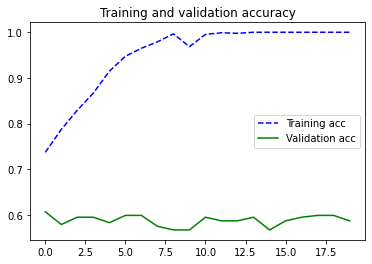

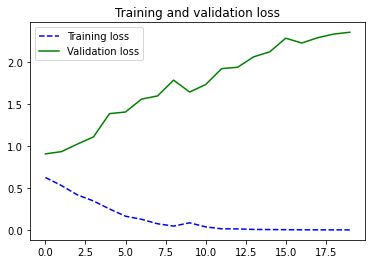

In [59]:
plot_training_analysis()